In [81]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# ==========================
# MultiHeadAttention Block
# ==========================
class MultiHeadAttentionblock(nn.Module):
    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model   # Embedding size
        self.h = h               # Number of heads
        assert d_model % h == 0, "d_model is not divisible by h"
        self.d_k = d_model // h  # Dim per head

        # nn.Linear: applies x @ W^T + b (here bias=False)
        self.w_q = nn.Linear(d_model, d_model, bias=False)  # Wq ,q @ Wq^T
        self.w_k = nn.Linear(d_model, d_model, bias=False)  # Wk ,k @ Wk^T
        self.w_v = nn.Linear(d_model, d_model, bias=False)  # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False)  # Wo

        # nn.Dropout: randomly zeros some elements with prob=dropout during training
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        # query, key, value shapes: (batch, h, seq_len, d_k)
        d_k = query.shape[-1]

        # @ : batched matrix multiplication
        # key.transpose(-2, -1): swap last two dims so shape is (batch,h,d_k,seq_len)
        # result: (batch,h,seq_len,seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)

        if mask is not None:
            # masked_fill_: in-place set positions where mask==0 to a very low value
            attention_scores.masked_fill_(mask == 0, -1e9)

        # softmax over last dim (over seq_len), so each row sums to 1
        attention_scores = attention_scores.softmax(dim=-1)

        if dropout is not None:
            attention_scores = dropout(attention_scores)

        # attention_scores @ value:
        # (batch,h,seq_len,seq_len) @ (batch,h,seq_len,d_k) -> (batch,h,seq_len,d_k)
        return attention_scores @ value, attention_scores

    def forward(self, q, k, v, mask=None):
        # q,k,v: (batch, seq_len, d_model)

        # 1) Linear projections to Q,K,V
        query = self.w_q(q)   # (batch, seq_len, d_model) 
        key   = self.w_k(k)   # (batch, seq_len, d_model)
        value = self.w_v(v)   # (batch, seq_len, d_model)

        # 2) Reshape to multiple heads
        # .view: reshape tensor
        # .transpose(1,2): swap seq_len and h dims
        # (batch,seq_len,d_model) -> (batch,seq_len,h,d_k) -> (batch,h,seq_len,d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key   = key.view(key.shape[0],   key.shape[1],   self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        # 3) Scaled dot-product attention
        x, self.attention_scores = MultiHeadAttentionblock.attention(
            query, key, value, mask, self.dropout
        )

        # 4) Combine heads back
        # x: (batch,h,seq_len,d_k)
        # transpose -> (batch,seq_len,h,d_k)
        # contiguous(): ensure memory layout is contiguous for view
        # view -> (batch,seq_len,h*d_k) == (batch,seq_len,d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        # 5) Final linear projection
        return self.w_o(x)    # (batch,seq_len,d_model)

#

In [82]:
 #==========================
# DEMO: run step-by-step
# ==========================
print("=== MULTI-HEAD ATTENTION DEMO ===\n")

# Tiny dimensions for demo
d_model = 4    # embedding size
h = 2          # heads
dropout = 0.1  # disable dropout for deterministic output
batch_size = 1
seq_len = 3

# sample "sentence": 1 batch of 3 tokens with 4-dim embeddings
# Let's pretend: token0="The", token1="cat", token2="sat"
x = torch.tensor([[[1.0, 0.5, 0.0, -1.0],
                   [0.0, 1.0, 0.5, -0.5],
                   [1.0, -0.5, 1.0, 0.0]]])  # shape (1,3,4) [[xxxx],[xxxx],[xxxx]]

print("Input x shape:", x.shape)
print("Input x:\n", x, "\n")

# No mask for now (full attention)
mask = None

=== MULTI-HEAD ATTENTION DEMO ===

Input x shape: torch.Size([1, 3, 4])
Input x:
 tensor([[[ 1.0000,  0.5000,  0.0000, -1.0000],
         [ 0.0000,  1.0000,  0.5000, -0.5000],
         [ 1.0000, -0.5000,  1.0000,  0.0000]]]) 



In [83]:
mha = MultiHeadAttentionblock(d_model=d_model, h=h, dropout=dropout)
print(mha)

MultiHeadAttentionblock(
  (w_q): Linear(in_features=4, out_features=4, bias=False)
  (w_k): Linear(in_features=4, out_features=4, bias=False)
  (w_v): Linear(in_features=4, out_features=4, bias=False)
  (w_o): Linear(in_features=4, out_features=4, bias=False)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [84]:
mha.dropout

Dropout(p=0.1, inplace=False)

In [108]:
# ---- Step 1: Linear projections ----
q = k = v = x  # self-attention: q,k,v all come from same x (input)
print("Step 1: Linear projections (Wq, Wk, Wv)")
Q = mha.w_q(q)
K = mha.w_k(k)
V = mha.w_v(v)
print("Q shape:", Q.shape)
print("Q:\n", Q, "\n")

Step 1: Linear projections (Wq, Wk, Wv)
Q shape: torch.Size([1, 3, 4])
Q:
 tensor([[[-0.7027,  0.0594,  0.0448, -0.3749],
         [ 0.1213, -0.1253, -0.5675, -0.1440],
         [ 0.0326, -0.5970, -0.2311,  0.2041]]], grad_fn=<UnsafeViewBackward0>) 



In [109]:
###understanding view method
x = torch.arange(12).reshape(1, 3, 4)  # (1,3,4) = 12 elements
print(x.shape)  # torch.Size([1, 3, 4])
print(x)
# Reshape to heads: (1,3,2,2) = still 12 elements!
x_heads = x.view(1, 3, 2, 2)  
print(x_heads.shape) 
print(x_heads)# torch.Size([1, 3, 2, 2])

# Data is SAME, just reinterpreted!
print("Original:", x[0,0])     # tensor([0,1,2,3])
print("Heads:   ", x_heads[0,0]) # tensor([[0,1], [2,3]])


torch.Size([1, 3, 4])
tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]]])
torch.Size([1, 3, 2, 2])
tensor([[[[ 0,  1],
          [ 2,  3]],

         [[ 4,  5],
          [ 6,  7]],

         [[ 8,  9],
          [10, 11]]]])
Original: tensor([0, 1, 2, 3])
Heads:    tensor([[0, 1],
        [2, 3]])


In [110]:
# ---- Step 2: Reshape into heads ----
print("Step 2: Reshape into heads")
##view -reshapes the tensor , transpose(d1,d2)  -swaps d1 and d2 ,
#Why? Attention needs shape (batch, h, seq_len, d_k) so each head can process all tokens together.
Q_heads = Q.view(batch_size, seq_len, h, mha.d_k).transpose(1, 2)
K_heads = K.view(batch_size, seq_len, h, mha.d_k).transpose(1, 2)
V_heads = V.view(batch_size, seq_len, h, mha.d_k).transpose(1, 2)
print("Q_heads shape before and after transpose:",Q.view(batch_size, seq_len, h, mha.d_k).shape, Q_heads.shape)  # (1,2,3,2)
print("\n Q_heads before  transpose:\n", Q.view(batch_size, seq_len, h, mha.d_k),"\n after transpose",Q_heads, "\n")

Step 2: Reshape into heads
Q_heads shape before and after transpose: torch.Size([1, 3, 2, 2]) torch.Size([1, 2, 3, 2])

 Q_heads before  transpose:
 tensor([[[[-0.7027,  0.0594],
          [ 0.0448, -0.3749]],

         [[ 0.1213, -0.1253],
          [-0.5675, -0.1440]],

         [[ 0.0326, -0.5970],
          [-0.2311,  0.2041]]]], grad_fn=<ViewBackward0>) 
 after transpose tensor([[[[-0.7027,  0.0594],
          [ 0.1213, -0.1253],
          [ 0.0326, -0.5970]],

         [[ 0.0448, -0.3749],
          [-0.5675, -0.1440],
          [-0.2311,  0.2041]]]], grad_fn=<TransposeBackward0>) 



### Understanding Attention in Detail

In [88]:
print("=== SCALED DOT-PRODUCT ATTENTION STEP-BY-STEP ===\n")

# 1. Setup: tiny example (batch=1, h=2, seq_len=3, d_k=2)
batch = 1
h = 2        # number of heads
seq_len = 3  # "The cat sat"
d_k = 2      # dimension per head d_model //h 

# Create tiny Q, K, V tensors (already split into heads)
Q = torch.tensor([[[[1.0, 0.5],    # Head 0: The
                     [0.8, 0.3],    # Head 0: cat
                     [0.6, 0.4]],   # Head 0: sat

                    [[0.3, 0.9],    # Head 1: The
                     [0.7, 0.2],    # Head 1: cat
                     [0.5, 0.6]]]])  # Head 1: sat  → (1,2,3,2)

K = torch.tensor([[[[0.9, 0.1],    # Head 0: The
                     [0.4, 0.7],    # Head 0: cat
                     [0.3, 0.8]],   # Head 0: sat

                    [[0.6, 0.4],    # Head 1: The
                     [0.2, 0.8],    # Head 1: cat
                     [0.7, 0.3]]]])  # Head 1: sat

V = torch.tensor([[[[1.2, 0.3],    # Head 0: The
                     [0.9, 0.6],    # Head 0: cat
                     [0.7, 1.1]],   # Head 0: sat

                    [[0.8, 0.5],    # Head 1: The
                     [1.0, 0.4],    # Head 1: cat
                     [0.6, 0.9]]]])  # Head 1: sat

mask = None  # No masking for now
dropout = nn.Dropout(0.1)  # Disable for clarity

print("Input shapes:")
print("Q:", Q.shape)  # (1, 2, 3, 2) = (batch, h, seq_len, d_k)
print("K:", K.shape)
print("V:", V.shape)
print()

=== SCALED DOT-PRODUCT ATTENTION STEP-BY-STEP ===

Input shapes:
Q: torch.Size([1, 2, 3, 2])
K: torch.Size([1, 2, 3, 2])
V: torch.Size([1, 2, 3, 2])



In [89]:
print(K.shape,K.shape[-2])

torch.Size([1, 2, 3, 2]) 3


In [90]:
# ====================
# STEP 1: Q @ K^T (dot products)
# ====================
print("STEP 1: Compute Q @ K^T")
print("=" * 50)

# torch.transpose(-2, -1): swap last two dimensions
# K shape: (1,2,3,2) → K^T: (1,2,2,3)
K_transposed = K.transpose(-2, -1)
print('original K and transposed K', K ,'\n **** \n',K_transposed)
print("K^T shape:", K_transposed.shape)  # (1,2,2,3)
print()

STEP 1: Compute Q @ K^T
original K and transposed K tensor([[[[0.9000, 0.1000],
          [0.4000, 0.7000],
          [0.3000, 0.8000]],

         [[0.6000, 0.4000],
          [0.2000, 0.8000],
          [0.7000, 0.3000]]]]) 
 **** 
 tensor([[[[0.9000, 0.4000, 0.3000],
          [0.1000, 0.7000, 0.8000]],

         [[0.6000, 0.2000, 0.7000],
          [0.4000, 0.8000, 0.3000]]]])
K^T shape: torch.Size([1, 2, 2, 3])



In [91]:
# Matrix multiplication: Q @ K^T
# (1,2,3,2) @ (1,2,2,3) → (1,2,3,3)
# @: batch matrix multiplication (bmm for last 2 dims)
attention_scores = Q @ K_transposed
print("attention_scores = Q @ K^T")
print("Shape:", attention_scores.shape)  # (1,2,3,3)
print('attention scores \n ***** \n' ,attention_scores)
print("\nHead 0 scores (before scaling):")
print(attention_scores[0, 0])
print()

# Interpretation: attention_scores[0, h, i, j] = how much token i attends to token j
print("Meaning: attention_scores[batch=0, head=0, token_i, token_j]")
print(f"'cat'(i=1) • 'The'(j=0) = {attention_scores[0,0,1,0].item():.3f}")
print(f"'cat'(i=1) • 'cat'(j=1) = {attention_scores[0,0,1,1].item():.3f}")
print(f"'cat'(i=1) • 'sat'(j=2) = {attention_scores[0,0,1,2].item():.3f}")
print()

attention_scores = Q @ K^T
Shape: torch.Size([1, 2, 3, 3])
attention scores 
 ***** 
 tensor([[[[0.9500, 0.7500, 0.7000],
          [0.7500, 0.5300, 0.4800],
          [0.5800, 0.5200, 0.5000]],

         [[0.5400, 0.7800, 0.4800],
          [0.5000, 0.3000, 0.5500],
          [0.5400, 0.5800, 0.5300]]]])

Head 0 scores (before scaling):
tensor([[0.9500, 0.7500, 0.7000],
        [0.7500, 0.5300, 0.4800],
        [0.5800, 0.5200, 0.5000]])

Meaning: attention_scores[batch=0, head=0, token_i, token_j]
'cat'(i=1) • 'The'(j=0) = 0.750
'cat'(i=1) • 'cat'(j=1) = 0.530
'cat'(i=1) • 'sat'(j=2) = 0.480



In [92]:
# ====================
# STEP 2: Scale by √d_k
# ====================
print("STEP 2: Scale by √d_k")
print("=" * 50)

scale_factor = math.sqrt(d_k)
print(f"d_k = {d_k}, √d_k = {scale_factor:.3f}")

attention_scores = attention_scores / scale_factor
print("\nAfter scaling (attention_scores / √d_k):")
print("Head 0 scaled scores:")
print(attention_scores[0, 0])
print()

print("WHY scale? Prevents large dot products from dominating softmax!")
print(f"Example: dot_product=10 → exp(10)={math.exp(10):.0f} (HUGE!)")
print(f"         scaled=10/√64=1.25 → exp(1.25)={math.exp(1.25):.1f} (manageable)")
print()

STEP 2: Scale by √d_k
d_k = 2, √d_k = 1.414

After scaling (attention_scores / √d_k):
Head 0 scaled scores:
tensor([[0.6718, 0.5303, 0.4950],
        [0.5303, 0.3748, 0.3394],
        [0.4101, 0.3677, 0.3536]])

WHY scale? Prevents large dot products from dominating softmax!
Example: dot_product=10 → exp(10)=22026 (HUGE!)
         scaled=10/√64=1.25 → exp(1.25)=3.5 (manageable)



In [93]:
# ====================
# STEP 3: Apply mask (if provided)
# ====================
print("STEP 3: Apply mask (optional)")
print("=" * 50)

if mask is not None:
    print("Mask provided, applying...")
    # masked_fill_(condition, value): set positions where condition==True to value
    # mask==0 means "don't attend here" → set to very negative value
    attention_scores.masked_fill_(mask == 0, -1e9)
    print("After masking (positions with mask=0 set to -1e9):")
    print(attention_scores[0, 0])
else:
    print("No mask provided, skipping.")
print()

STEP 3: Apply mask (optional)
No mask provided, skipping.



In [94]:
# Understanding Msking -|Prevent token i from attending to token j > i (future tokens)
mask = torch.tensor([[1, 0, 0],   # Token 0 can only see itself
                     [1, 1, 0],   # Token 1 sees 0,1
                     [1, 1, 1]])  # Token 2 sees all

# Attention scores before masking
scores = torch.tensor([[ 0.5,  0.3,  0.8],  # Token 0
                       [ 0.2,  0.6,  0.4],  # Token 1
                       [ 0.9,  0.1,  0.7]]) # Token 2

print("Before masking:\n", scores)

# Apply mask: where mask==0, set to very negative value
scores.masked_fill_(mask == 0, -1e9) ##in place
print("\nAfter masking:\n", scores)


Before masking:
 tensor([[0.5000, 0.3000, 0.8000],
        [0.2000, 0.6000, 0.4000],
        [0.9000, 0.1000, 0.7000]])

After masking:
 tensor([[ 5.0000e-01, -1.0000e+09, -1.0000e+09],
        [ 2.0000e-01,  6.0000e-01, -1.0000e+09],
        [ 9.0000e-01,  1.0000e-01,  7.0000e-01]])


In [95]:
# ====================
# STEP 4: Softmax (turn scores into probabilities)
# ====================
print("STEP 4: Apply softmax (dim=-1)")
print("=" * 50)

# softmax over last dimension (over keys/columns)
# Each row sums to 1.0
attention_weights = attention_scores.softmax(dim=-1)
print("Softmax formula: exp(x_i) / sum(exp(x_j)) for each row")
print("\nAttention weights (after softmax):")
print("Head 0 weights:")
print(attention_weights[0, 0])
print()

print("Row sums (should be ~1.0):")
print(attention_weights[0, 0].sum(dim=1))
print()

print("Interpretation for 'cat' (row 1):")
print(f"'cat' attends to 'The': {attention_weights[0,0,1,0].item():.3f} (30%)")
print(f"'cat' attends to 'cat': {attention_weights[0,0,1,1].item():.3f} (self)")
print(f"'cat' attends to 'sat': {attention_weights[0,0,1,2].item():.3f}")
print()

STEP 4: Apply softmax (dim=-1)
Softmax formula: exp(x_i) / sum(exp(x_j)) for each row

Attention weights (after softmax):
Head 0 weights:
tensor([[0.3695, 0.3208, 0.3097],
        [0.3728, 0.3191, 0.3080],
        [0.3444, 0.3301, 0.3255]])

Row sums (should be ~1.0):
tensor([1.0000, 1.0000, 1.0000])

Interpretation for 'cat' (row 1):
'cat' attends to 'The': 0.373 (30%)
'cat' attends to 'cat': 0.319 (self)
'cat' attends to 'sat': 0.308



In [96]:
# ====================
# STEP 5: Apply dropout to attention weights - for robust learning , forces model not to rely on single attention connections.
# ====================
print("STEP 5: Apply dropout to attention weights")
print("=" * 50)

if dropout is not None:
    attention_weights_before = attention_weights.clone()
    attention_weights = dropout(attention_weights)
    print("Dropout applied (randomly zeros ~p% of weights during training)")
    print("Before dropout:", attention_weights_before[0, 0, 0],attention_weights_before)
    print("After dropout: ", attention_weights[0, 0, 0],attention_weights)
else:
    print("No dropout.")
print()

STEP 5: Apply dropout to attention weights
Dropout applied (randomly zeros ~p% of weights during training)
Before dropout: tensor([0.3695, 0.3208, 0.3097]) tensor([[[[0.3695, 0.3208, 0.3097],
          [0.3728, 0.3191, 0.3080],
          [0.3444, 0.3301, 0.3255]],

         [[0.3181, 0.3770, 0.3049],
          [0.3443, 0.2989, 0.3567],
          [0.3309, 0.3404, 0.3286]]]])
After dropout:  tensor([0.4106, 0.3564, 0.3441]) tensor([[[[0.4106, 0.3564, 0.3441],
          [0.4143, 0.3546, 0.3423],
          [0.3827, 0.3668, 0.3616]],

         [[0.3535, 0.4188, 0.3388],
          [0.3826, 0.3321, 0.3964],
          [0.3677, 0.3783, 0.3651]]]])



In [97]:
dropout

Dropout(p=0.1, inplace=False)

In [98]:
###Pytorch Implementation of Dropout###
# class Dropout(nn.Module):
#     def __init__(self, p=0.5):
#         super().__init__()
#         self.p = p
    
#     def forward(self, x):
#         if self.training:  # Only during training
#             # Generate binary mask
#             mask = (torch.rand_like(x) > self.p).float()
#             # Apply mask and scale
#             return x * mask / (1 - self.p)
#         else:  # Inference
#             return x


In [99]:
V ,attention_weights

(tensor([[[[1.2000, 0.3000],
           [0.9000, 0.6000],
           [0.7000, 1.1000]],
 
          [[0.8000, 0.5000],
           [1.0000, 0.4000],
           [0.6000, 0.9000]]]]),
 tensor([[[[0.4106, 0.3564, 0.3441],
           [0.4143, 0.3546, 0.3423],
           [0.3827, 0.3668, 0.3616]],
 
          [[0.3535, 0.4188, 0.3388],
           [0.3826, 0.3321, 0.3964],
           [0.3677, 0.3783, 0.3651]]]]))

In [100]:
# ====================
# STEP 6: Weighted sum of Values (attention_weights @ V)
# ====================
print("STEP 6: Compute weighted sum of Values")
print("=" * 50)

# (1,2,3,3) @ (1,2,3,2) → (1,2,3,2)
# For each token, compute weighted average of all V vectors
output = attention_weights @ V
print("output = attention_weights @ V")
print("Shape:", output.shape)  # (1,2,3,2)
print("\nHead 0 output:")
print(output[0, 0])
print()

print("Interpretation for 'cat' output (row 1):")
print(f"output[cat] = {attention_weights[0,0,1,0].item():.2f}×V[The] + {attention_weights[0,0,1,1].item():.2f}×V[cat] + {attention_weights[0,0,1,2].item():.2f}×V[sat]")
print(f"            = {attention_weights[0,0,1,0].item():.2f}×{V[0,0,0].numpy()} + {attention_weights[0,0,1,1].item():.2f}×{V[0,0,1].numpy()} + {attention_weights[0,0,1,2].item():.2f}×{V[0,0,2].numpy()}")
print(f"            = {output[0,0,1].numpy()}")
print()

STEP 6: Compute weighted sum of Values
output = attention_weights @ V
Shape: torch.Size([1, 2, 3, 2])

Head 0 output:
tensor([[1.0544, 0.7155],
        [1.0558, 0.7135],
        [1.0425, 0.7327]])

Interpretation for 'cat' output (row 1):
output[cat] = 0.41×V[The] + 0.35×V[cat] + 0.34×V[sat]
            = 0.41×[1.2 0.3] + 0.35×[0.9 0.6] + 0.34×[0.7 1.1]
            = [1.0558264 0.71352  ]



In [101]:
# ====================
# STEP 7: Return both output and attention weights
# ====================
print("STEP 7: Return output and attention scores")
print("=" * 50)
print("Returned values:")
print("1. output (contextual embeddings):", output.shape)
print("2. attention_weights (for visualization):", attention_weights.shape)
print()

print("✅ DONE! Each token now has context from all other tokens via attention!")


STEP 7: Return output and attention scores
Returned values:
1. output (contextual embeddings): torch.Size([1, 2, 3, 2])
2. attention_weights (for visualization): torch.Size([1, 2, 3, 3])

✅ DONE! Each token now has context from all other tokens via attention!


### Attention Applied by Method Calling

In [111]:
# ---- Step 3: Scaled dot-product attention per head ----
print("Step 3: Scaled dot-product attention")
att_out, att_scores = MultiHeadAttentionblock.attention(Q_heads, K_heads, V_heads, mask, mha.dropout)
print("Attention scores shape:", att_scores.shape)  # (1,2,3,3)
print("Attention scores (head 0):\n", att_scores[0,0], "\n")
print("Attention output per head shape:", att_out.shape)  # (1,2,3,2)
print("Attention output (head 0):\n", att_out[0,0], "\n"),att_out

Step 3: Scaled dot-product attention
Attention scores shape: torch.Size([1, 2, 3, 3])
Attention scores (head 0):
 tensor([[0.4075, 0.0000, 0.3450],
        [0.3584, 0.3687, 0.3840],
        [0.3389, 0.3521, 0.4201]], grad_fn=<SelectBackward0>) 

Attention output per head shape: torch.Size([1, 2, 3, 2])
Attention output (head 0):
 tensor([[-0.0895, -0.2118],
        [ 0.1105, -0.1021],
        [ 0.0800, -0.1275]], grad_fn=<SelectBackward0>) 



(None,
 tensor([[[[-0.0895, -0.2118],
           [ 0.1105, -0.1021],
           [ 0.0800, -0.1275]],
 
          [[-0.5136,  0.2257],
           [-0.5162,  0.2186],
           [-0.5118,  0.2310]]]], grad_fn=<UnsafeViewBackward0>))

In [112]:
# ---- Step 4: Combine heads ----
print("Step 4: Combine heads and apply Wo")
x_heads_combined = att_out.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
print("Combined heads shape:", x_heads_combined.shape)
print("Combined heads:\n", x_heads_combined, "\n")

Step 4: Combine heads and apply Wo
Combined heads shape: torch.Size([1, 3, 4])
Combined heads:
 tensor([[[-0.0895, -0.2118, -0.5136,  0.2257],
         [ 0.1105, -0.1021, -0.5162,  0.2186],
         [ 0.0800, -0.1275, -0.5118,  0.2310]]], grad_fn=<ViewBackward0>) 



In [113]:
final_out = mha.w_o(x_heads_combined)
print("Final output shape:", final_out.shape)
print("Final output:\n", final_out, "\n")

Final output shape: torch.Size([1, 3, 4])
Final output:
 tensor([[[-0.1111,  0.0893, -0.0743, -0.1915],
         [-0.0199,  0.1096,  0.0212, -0.1346],
         [-0.0419,  0.1061,  0.0028, -0.1444]]], grad_fn=<UnsafeViewBackward0>) 



In [115]:
 #==========================
# DEMO:create the sample input and object of multiheadattention block class
# ==========================
print("=== MULTI-HEAD ATTENTION DEMO ===\n")

# Tiny dimensions for demo
d_model = 4    # embedding size
h = 2          # heads
dropout = 0.1  # disable dropout for deterministic output
batch_size = 1
seq_len = 3

# sample "sentence": 1 batch of 3 tokens with 4-dim embeddings
# Let's pretend: token0="The", token1="cat", token2="sat"
x = torch.tensor([[[1.0, 0.5, 0.0, -1.0],
                   [0.0, 1.0, 0.5, -0.5],
                   [1.0, -0.5, 1.0, 0.0]]])  # shape (1,3,4) [[xxxx],[xxxx],[xxxx]]

print("Input x shape:", x.shape)
print("Input x:\n", x, "\n")

# No mask for now (full attention)
mask = None

mha = MultiHeadAttentionblock(d_model=d_model, h=h, dropout=dropout)
print(mha)

=== MULTI-HEAD ATTENTION DEMO ===

Input x shape: torch.Size([1, 3, 4])
Input x:
 tensor([[[ 1.0000,  0.5000,  0.0000, -1.0000],
         [ 0.0000,  1.0000,  0.5000, -0.5000],
         [ 1.0000, -0.5000,  1.0000,  0.0000]]]) 

MultiHeadAttentionblock(
  (w_q): Linear(in_features=4, out_features=4, bias=False)
  (w_k): Linear(in_features=4, out_features=4, bias=False)
  (w_v): Linear(in_features=4, out_features=4, bias=False)
  (w_o): Linear(in_features=4, out_features=4, bias=False)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [117]:

# ---- Step 5: End-to-end forward ----
print("Step 5: Using mha(x,x,x) directly ")
end_to_end = mha(x, x, x, mask)
print("end_to_end shape:", end_to_end.shape)
print(end_to_end)

Step 5: Using mha(x,x,x) directly (should match final_out)
end_to_end shape: torch.Size([1, 3, 4])
tensor([[[-0.0044,  0.1587,  0.1138, -0.1092],
         [ 0.0002,  0.0623,  0.0565, -0.0799],
         [-0.0131,  0.1359,  0.0946, -0.0806]]], grad_fn=<UnsafeViewBackward0>)


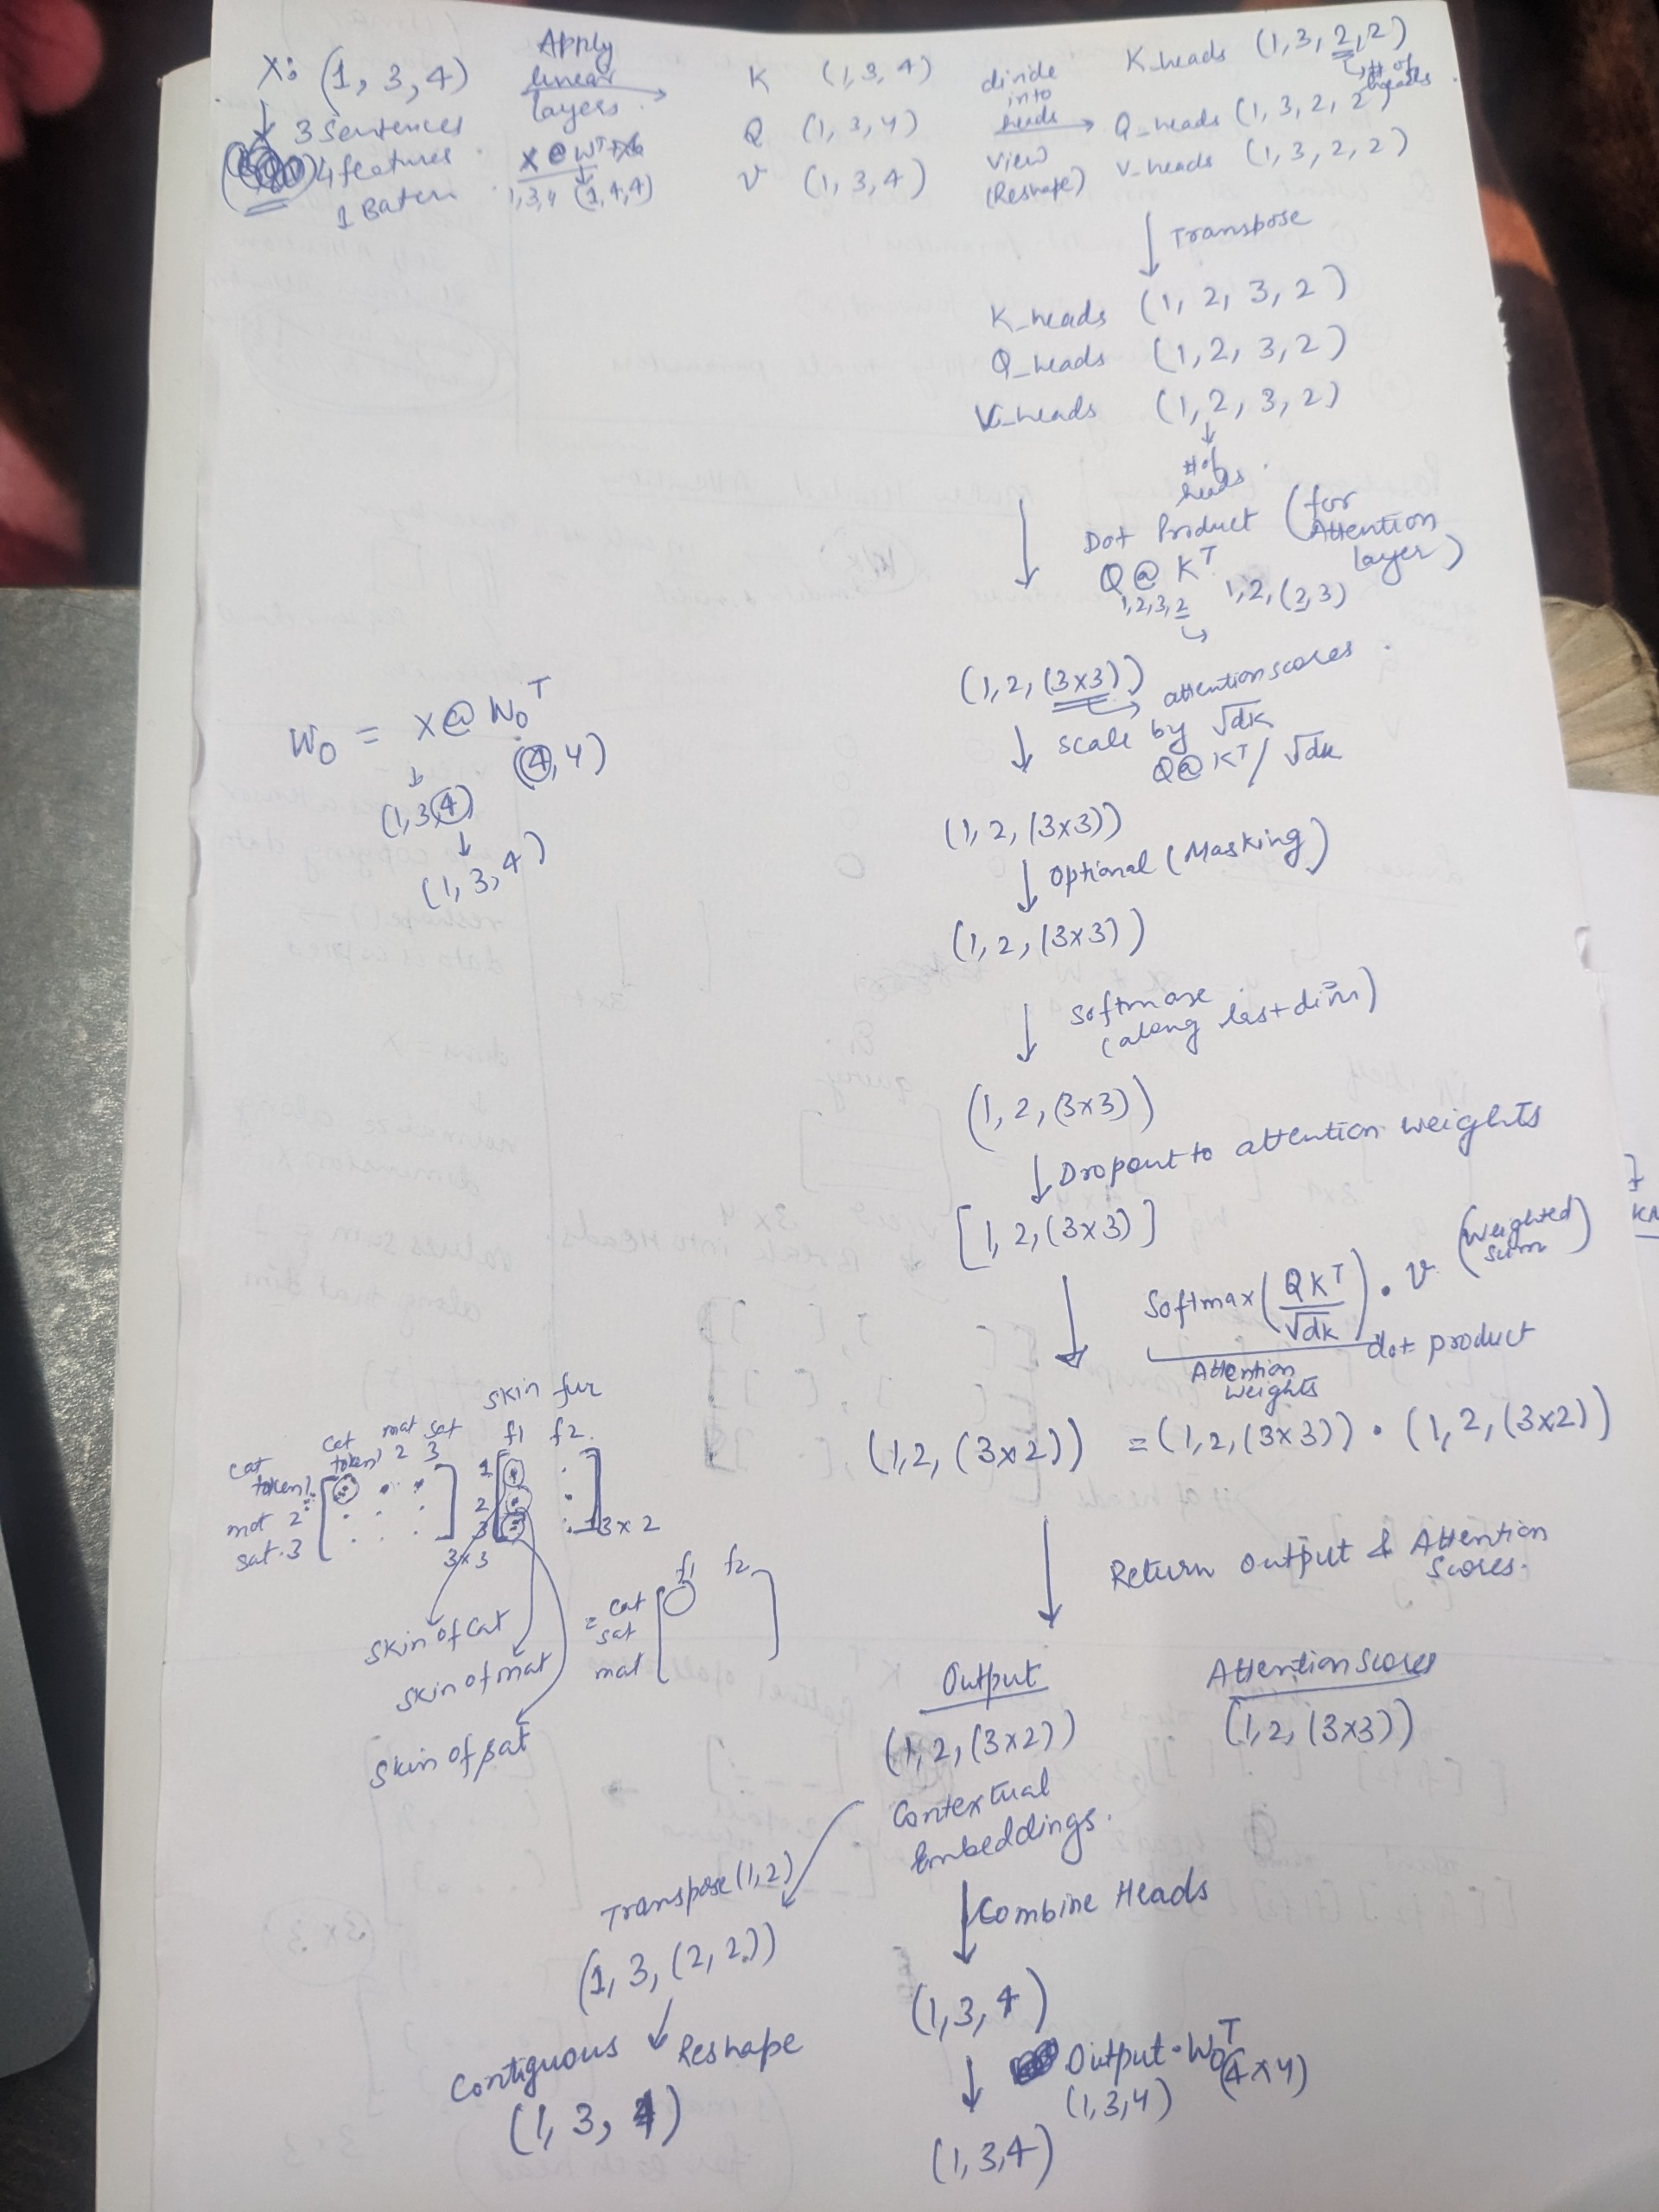